In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.linalg import sqrtm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

In [189]:
# Lecture des données
transfer_data = pd.read_csv('transfers.csv')

# Exploration initiale
print("Format des données initiales :", transfer_data.shape)
print("\nColonnes disponibles :", transfer_data.columns.tolist())

# Valeurs uniques dans 'transfer_season'
unique_last_seasons = transfer_data['transfer_season'].unique()
print("\nValeurs uniques pour 'transfer_season' allant de :", unique_last_seasons[-1], "à", unique_last_seasons[0])

# Conversion et extraction des dates
transfer_data['transfer_date'] = pd.to_datetime(transfer_data['transfer_date'], errors='coerce')
transfer_data['transfer_year'] = transfer_data['transfer_date'].dt.year

# Suppression des colonnes inutiles
columns_to_delete = ['player_id', 'transfer_season', 'transfer_date']  # Le mois du transfert pourrait être intéressant
transfer_data = transfer_data.drop(columns=columns_to_delete, errors='ignore')

# Nettoyage des données
cleaned_transfer_data = transfer_data.dropna()
cleaned_transfer_data = cleaned_transfer_data[cleaned_transfer_data['transfer_fee'] != 0]

print("\nFormat après nettoyage :", cleaned_transfer_data.shape)

# Exploration des clubs et des joueurs uniques
print("\nNombre de clubs différents (origine) :", cleaned_transfer_data['from_club_name'].nunique())
print("\nNombre de clubs différents (destination) :", cleaned_transfer_data['to_club_name'].nunique())
print("\nNombre de joueurs différents :", cleaned_transfer_data['player_name'].nunique())

# Aperçu des données nettoyées
print("\nAperçu des données nettoyées :")
cleaned_transfer_data.head()

Format des données initiales : (76860, 10)

Colonnes disponibles : ['player_id', 'transfer_date', 'transfer_season', 'from_club_id', 'to_club_id', 'from_club_name', 'to_club_name', 'transfer_fee', 'market_value_in_eur', 'player_name']

Valeurs uniques pour 'transfer_season' allant de : 93/94 à 25/26

Format après nettoyage : (8450, 8)

Nombre de clubs différents (origine) : 1461

Nombre de clubs différents (destination) : 875

Nombre de joueurs différents : 4778

Aperçu des données nettoyées :


,from_club_id,to_club_id,from_club_name,to_club_name,transfer_fee,market_value_in_eur,player_name,transfer_year
7,294,114,Benfica,Besiktas,2000000.0,3800000.0,João Mário,2025
10,167,114,FC Augsburg,Besiktas,5000000.0,8500000.0,Felix Uduokhai,2025
11,39,3911,1.FSV Mainz 05,Stade Brestois,2000000.0,3000000.0,Ludovic Ajorque,2025
12,430,36,Fiorentina,Fenerbahce,13000000.0,22000000.0,Sofyan Amrabat,2025
13,2919,506,Monza,Juventus,14300000.0,18000000.0,Michele Di Gregorio,2025


In [190]:
# Fonction pour nettoyer et convertir les valeurs en nombres positifs
def clean_and_convert(value):
    """
    Nettoie une valeur de transfert et la convertit en float.
    Suppression des symboles (€,+,-), gestion des multiplicateurs (m, k) et gestion des erreurs.
    """
    try:
        if pd.isna(value):
            return 0  
        value = re.sub(r'[€+]', '', str(value))  
        value = re.sub(r'-', '', value)
        value = value.replace('m', 'e6').replace('k', 'e3')
        return float(value)
    except ValueError:
        print(f"Erreur de conversion pour la valeur : {value}")
        return 0

# Chargement des données
clubs_data = pd.read_csv('clubs.csv')

print("Format initial des données :", clubs_data.shape)

# Suppression des colonnes inutiles
columns_to_delete = [
    'club_code', 'squad_size', 'foreigners_number', 'total_market_value',
    'foreigners_percentage', 'national_team_players', 'stadium_name',
    'stadium_seats', "coach_name", "filename", "url"
]
clubs_data = clubs_data.drop(columns=columns_to_delete)

# Nettoyage de la colonne 'net_transfer_record'
net_transfer_record = clubs_data['net_transfer_record']
clubs_data['net_transfer_record'] = [clean_and_convert(val) for val in net_transfer_record]

# Catégorisation en quartiles
clubs_data['net_transfer_record'] = pd.qcut(
    clubs_data['net_transfer_record'], q=4, labels=['Low', 'Medium', 'High', 'Very High']
)

# Exploration des données
print("\nColonnes disponibles :", clubs_data.columns.tolist())
print("\nCatégories pour 'net_transfer_record' :", clubs_data['net_transfer_record'].unique())
print("\nCompétitions nationales uniques :", clubs_data['domestic_competition_id'].unique())

# Afficher un résumé des catégories
print("\nDistribution des catégories pour 'net_transfer_record' :")
print(clubs_data['net_transfer_record'].value_counts())

# Aperçu des données nettoyées
clubs_data.head()

Format initial des données : (439, 17)

Colonnes disponibles : ['club_id', 'name', 'domestic_competition_id', 'average_age', 'net_transfer_record', 'last_season']

Catégories pour 'net_transfer_record' : ['High', 'Medium', 'Very High', 'Low']
Categories (4, object): ['Low' < 'Medium' < 'High' < 'Very High']

Compétitions nationales uniques : ['L1' 'RU1' 'TR1' 'IT1' 'GB1' 'BE1' 'DK1' 'NL1' 'GR1' 'PO1' 'SC1' 'ES1'
 'UKR1' 'FR1']

Distribution des catégories pour 'net_transfer_record' :
net_transfer_record
Low          110
Medium       110
Very High    110
High         109
Name: count, dtype: int64


,club_id,name,domestic_competition_id,average_age,net_transfer_record,last_season
0,105,SV Darmstadt 98,L1,25.6,High,2023
1,11127,Ural Yekaterinburg,RU1,26.5,Medium,2023
2,114,Beşiktaş Jimnastik Kulübü,TR1,26.3,Very High,2024
3,12,Associazione Sportiva Roma,IT1,26.3,Very High,2024
4,148,Tottenham Hotspur Football Club,GB1,25.4,Very High,2024


In [191]:
club_games_data = pd.read_csv('club_games.csv')

# Exploration initiale
print("Colonnes disponibles :", club_games_data.columns.tolist())
print("Format initial des données :", club_games_data.shape)

# Nettoyage des données
columns_to_delete = ["opponent_manager_name", "own_manager_name", "hosting"]
club_games_data = club_games_data.drop(columns=columns_to_delete)
club_games_data = club_games_data.dropna()

# Indexation
# club_games_data.set_index('game_id', inplace=True)

# Exploration après nettoyage
print("\nColonnes restantes :", club_games_data.columns.tolist())
print("\nFormat des données après nettoyage :", club_games_data.shape)
print("Nombre de clés uniques dans club_games_data :", club_games_data['game_id'].nunique()) # Les clés game_id ne sont pas uniques car chaque match est présent deux fois
club_games_data = club_games_data.drop_duplicates(subset=['game_id'])
print("Doublons dans club_games_data :", club_games_data['game_id'].duplicated().sum())


print("\nAperçu des données nettoyées :")
club_games_data.head()

Colonnes disponibles : ['game_id', 'club_id', 'own_goals', 'own_position', 'own_manager_name', 'opponent_id', 'opponent_goals', 'opponent_position', 'opponent_manager_name', 'hosting', 'is_win']
Format initial des données : (143022, 11)

Colonnes restantes : ['game_id', 'club_id', 'own_goals', 'own_position', 'opponent_id', 'opponent_goals', 'opponent_position', 'is_win']

Format des données après nettoyage : (99364, 8)
Nombre de clés uniques dans club_games_data : 49682
Doublons dans club_games_data : 0

Aperçu des données nettoyées :


,game_id,club_id,own_goals,own_position,opponent_id,opponent_goals,opponent_position,is_win
3,2321044,16,2.0,1.0,23,1.0,15.0,1
4,2321060,23,0.0,18.0,24,2.0,11.0,0
5,2321063,33,2.0,13.0,15,0.0,3.0,1
6,2321086,4,1.0,15.0,16,1.0,1.0,0
7,2321152,44,0.0,7.0,33,2.0,6.0,0


In [192]:
# Charger les données
games_data = pd.read_csv('games.csv')

# Exploration initiale
print("Colonnes disponibles :", games_data.columns.tolist())
print("Format initial des données :", games_data.shape)

# Suppression des colonnes inutiles
columns_to_delete = [
    'round', 'date', 'attendance', 'stadium', 'url', 
    'home_club_goals', 'away_club_goals', 'home_club_manager_name', 
    'away_club_manager_name', 'referee', 'home_club_name', 
    'away_club_name', 'home_club_position', 'away_club_position', 'home_club_formation', 'away_club_formation'
]
games_data = games_data.drop(columns=columns_to_delete)
games_data = games_data.dropna()

# Exploration des colonnes restantes
print("\nValeurs uniques pour 'season' :", games_data['season'].unique())  # Vérification des saisons disponibles
print("\nValeurs uniques pour 'competition_id' :", games_data['competition_id'].unique())  # ID compétitions
print("\nValeurs uniques pour 'competition_type' :", games_data['competition_type'].unique())  # Type compétition

# Indexation
# games_data.set_index('game_id', inplace=True)

# Aperçu des données nettoyées
print("\nFormat des données après nettoyage :", games_data.shape)
print("\nAperçu des données nettoyées :")
games_data.head()

Colonnes disponibles : ['game_id', 'competition_id', 'season', 'round', 'date', 'home_club_id', 'away_club_id', 'home_club_goals', 'away_club_goals', 'home_club_position', 'away_club_position', 'home_club_manager_name', 'away_club_manager_name', 'stadium', 'attendance', 'referee', 'url', 'home_club_formation', 'away_club_formation', 'home_club_name', 'away_club_name', 'aggregate', 'competition_type']
Format initial des données : (71511, 23)

Valeurs uniques pour 'season' : [2013 2014 2015 2016 2017 2012 2018 2019 2020 2021 2022 2023 2024]

Valeurs uniques pour 'competition_id' : ['L1' 'RU1' 'BE1' 'FR1' 'GB1' 'SC1' 'UKR1' 'PO1' 'ES1' 'NL1' 'TR1' 'GR1'
 'IT1' 'POCP' 'EL' 'UKRP' 'CL' 'CDR' 'CIT' 'FAC' 'GRP' 'CLQ' 'ELQ' 'NLP'
 'DK1' 'DFB' 'RUP' 'DKP' 'POSU' 'SFA' 'GBCS' 'SUC' 'KLUB' 'ECLQ' 'USC'
 'UCOL' 'CGB' 'SCI' 'DFL' 'FRCH' 'RUSS' 'UKRS' 'NLSC' 'BESC']

Valeurs uniques pour 'competition_type' : ['domestic_league' 'domestic_cup' 'international_cup' 'other']

Format des données après net

,game_id,competition_id,season,home_club_id,away_club_id,aggregate,competition_type
0,2321044,L1,2013,16,23,2:1,domestic_league
1,2321060,L1,2013,23,24,0:2,domestic_league
2,2321086,L1,2013,4,16,1:1,domestic_league
3,2321152,L1,2013,44,33,0:2,domestic_league
4,2321205,L1,2013,41,39,2:3,domestic_league


In [193]:
# Fusion des données sur game_id
game_club_data = pd.merge(games_data, club_games_data, on="game_id", how="inner")  # Choisir 'inner' pour garder les correspondances exactes

# Vérification de la forme après fusion
print("Format des données fusionnées :", game_club_data.shape)

# Suppression des colonnes inutiles
columns_to_delete = [
    "opponent_goals", "own_goals", "club_id", "opponent_id", 
    'competition_id',
] # Pas besoin des formations de même pour hosting, il n' ya pas d'objectif de prédictions
game_club_data = game_club_data.drop(columns=columns_to_delete)

# Vérification des colonnes restantes
print("\nColonnes restantes après suppression :", game_club_data.columns.tolist())

# Exploration des données nettoyées
print("\nAperçu des données nettoyées :")
game_club_data.head()

Format des données fusionnées : (49682, 14)

Colonnes restantes après suppression : ['game_id', 'season', 'home_club_id', 'away_club_id', 'aggregate', 'competition_type', 'own_position', 'opponent_position', 'is_win']

Aperçu des données nettoyées :


,game_id,season,home_club_id,away_club_id,aggregate,competition_type,own_position,opponent_position,is_win
0,2321044,2013,16,23,2:1,domestic_league,1.0,15.0,1
1,2321060,2013,23,24,0:2,domestic_league,18.0,11.0,0
2,2321086,2013,4,16,1:1,domestic_league,15.0,1.0,0
3,2321152,2013,44,33,0:2,domestic_league,7.0,6.0,0
4,2321205,2013,41,39,2:3,domestic_league,14.0,9.0,0


In [194]:
game_club_data['aggregate'] = game_club_data['aggregate'].fillna('0:0')

# Séparer les scores en buts domicile et extérieur
game_club_data[['home_goals', 'away_goals']] = game_club_data['aggregate'].str.split(':', expand=True).astype(int)

# Calcul des buts marqués à domicile
home_goals = game_club_data.groupby(['season', 'home_club_id'])['home_goals'].sum().reset_index()
home_goals.rename(columns={'home_club_id': 'club_id', 'home_goals': 'total_goals'}, inplace=True)

# Calcul des buts marqués à l'extérieur
away_goals = game_club_data.groupby(['season', 'away_club_id'])['away_goals'].sum().reset_index()
away_goals.rename(columns={'away_club_id': 'club_id', 'away_goals': 'total_goals'}, inplace=True)

# Fusionner les buts à domicile et à l'extérieur
total_goals = pd.concat([home_goals, away_goals]).groupby(['season', 'club_id'])['total_goals'].sum().reset_index()

# Calcul des victoires à domicile (is_win == 1 pour home_club_id)
home_wins = game_club_data[game_club_data['is_win'] == 1].groupby(['season', 'home_club_id'])['is_win'].count().reset_index()
home_wins.rename(columns={'home_club_id': 'club_id', 'is_win': 'wins'}, inplace=True)

# Calcul des victoires à l'extérieur (is_win == 0 pour away_club_id)
away_wins = game_club_data[game_club_data['is_win'] == 0].groupby(['season', 'away_club_id'])['is_win'].count().reset_index()
away_wins.rename(columns={'away_club_id': 'club_id', 'is_win': 'wins'}, inplace=True)

# Fusionner les victoires domicile et extérieur
total_wins = pd.concat([home_wins, away_wins]).groupby(['season', 'club_id'])['wins'].sum().reset_index()

# Calcul de la moyenne et du meilleur classement par saison
positions = game_club_data.groupby(['season', 'home_club_id'])['own_position'].agg(
    median_position='median', #best_position='min'
).reset_index()
positions.rename(columns={'home_club_id': 'club_id'}, inplace=True)

# Fusion des statistiques (buts, victoires, positions)
final_stats = total_goals.merge(total_wins, on=['season', 'club_id'], how='left')
final_stats = final_stats.merge(positions, on=['season', 'club_id'], how='left')

final_stats['wins'] = final_stats['wins'].fillna(0).astype(int)
final_stats['median_position'] = round(final_stats['median_position'])
# Résultat final sans NaN
print("Format des données fusionnées :", final_stats.shape)

final_stats = final_stats.dropna()
print("Format des données fusionnées :", final_stats.shape)


final_stats.head()


Format des données fusionnées : (3105, 5)
Format des données fusionnées : (3104, 5)


,season,club_id,total_goals,wins,median_position
0,2012,4,39,16,13.0
1,2012,5,67,28,7.0
2,2012,11,72,26,5.0
3,2012,12,71,21,6.0
4,2012,13,65,28,2.0


In [195]:
# Création des datas pour transferts entrants et sortants
cleaned_transfer_data_receiver = cleaned_transfer_data.rename(columns={'to_club_id': 'club_id'})
cleaned_transfer_data_receiver = cleaned_transfer_data_receiver.rename(columns={'to_club_name': 'club_name'})
cleaned_transfer_data_receiver['club_role'] = 'receiver'
columns_to_delete = ["from_club_name"]
cleaned_transfer_data_receiver = cleaned_transfer_data_receiver.drop(columns=columns_to_delete)

cleaned_transfer_data_sender = cleaned_transfer_data.rename(columns={'from_club_id': 'club_id'})
cleaned_transfer_data_sender = cleaned_transfer_data_sender.rename(columns={'from_club_name': 'club_name'})
cleaned_transfer_data_sender['club_role'] = 'sender'
columns_to_delete = ["to_club_name"]
cleaned_transfer_data_sender = cleaned_transfer_data_sender.drop(columns=columns_to_delete)

# Fusion des transferts entrants et sortants dans un seul merged_data
transfers = pd.concat([cleaned_transfer_data_receiver, cleaned_transfer_data_sender], ignore_index=True)
columns_to_delete = ["from_club_id", "to_club_id"]
transfers = transfers.drop(columns=columns_to_delete)

merged_data = pd.merge(
    final_stats,
    transfers,
    how='left',
    left_on=['season', 'club_id'],
    right_on=['transfer_year', 'club_id']
)

columns_to_delete = ["club_id", "transfer_year", "club_name", "season"]
merged_data = merged_data.drop(columns=columns_to_delete)

# Supprimer les lignes où 'transfer_fee' est manquant
merged_data = merged_data.dropna(subset=['transfer_fee'])
print(merged_data.shape)
merged_data.head()

(10425, 7)


,total_goals,wins,median_position,transfer_fee,market_value_in_eur,player_name,club_role
1,67,28,7.0,3300000.0,1750000.0,M'Baye Niang,receiver
2,67,28,7.0,4000000.0,4500000.0,Francesco Acerbi,receiver
3,67,28,7.0,42000000.0,38000000.0,Thiago Silva,sender
4,67,28,7.0,1800000.0,4000000.0,Pierre-Emerick Aubameyang,sender
5,72,26,5.0,12000000.0,13000000.0,Olivier Giroud,receiver


In [196]:
# Séparer les données pour les clubs récepteurs et expéditeurs
receiver_club_data = merged_data[merged_data['club_role'] == 'receiver'].drop(columns=["club_role"])
sender_club_data = merged_data[merged_data['club_role'] == 'sender'].drop(columns=["club_role"])
print(receiver_club_data.shape)
print(sender_club_data.shape)

receiver_club_data.head()

(6201, 6)
(4224, 6)


,total_goals,wins,median_position,transfer_fee,market_value_in_eur,player_name
1,67,28,7.0,3300000.0,1750000.0,M'Baye Niang
2,67,28,7.0,4000000.0,4500000.0,Francesco Acerbi
5,72,26,5.0,12000000.0,13000000.0,Olivier Giroud
6,71,21,6.0,1250000.0,1500000.0,Alessandro Florenzi
9,65,28,2.0,13500000.0,7500000.0,Pizzi


In [197]:
# Définir les deux ensembles de variables
X_receiver = receiver_club_data[['total_goals', 'wins', 'median_position']]  # Performances
Y_receiver = receiver_club_data[['transfer_fee']]  # Transferts

<Axes: >

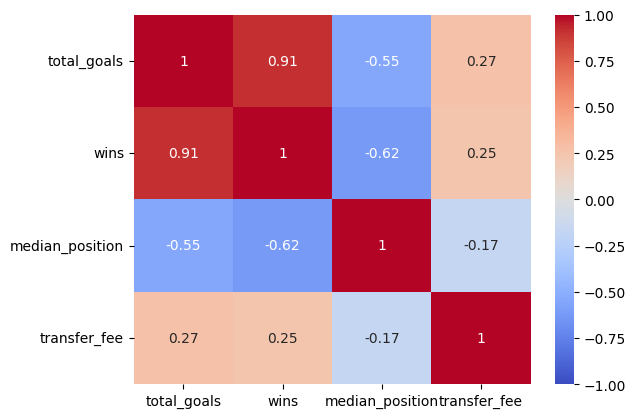

In [198]:
df_transfer = pd.concat([X_receiver, Y_receiver],axis=1)

# Calculer la matrice de corrélation
corr_matrix_transfer = df_transfer.corr()

# Créer une heatmap de la matrice de corrélation
sns.heatmap(corr_matrix_transfer, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)


In [199]:
def empirical_cov_mat(X,Y):
    nx = X.shape[0]
    ny = Y.shape[0] 
        
    X_c = X - np.mean(X, axis=0)
    Y_c = Y - np.mean(Y, axis=0)
    if nx != ny:
        print('ERROR : X,Y have not the same sample size')
    else:
        S_XX = (X_c.T.dot(X_c))/nx
        S_YY = (Y_c.T.dot(Y_c))/nx
        S_XY = (X_c.T.dot(Y_c))/nx
        S_YX = S_XY.T
    return S_XX,S_YY,S_XY,S_YX

def canonical_correlation_analysis(X, Y):
    
    # Step 1: Compute covariance matrices
    S_xx,S_yy,S_xy,S_yx = empirical_cov_mat(X,Y)
    
    # Step 2: Compute the inverse and sqrt of the covariance matrices
    if S_xx.size==1:
        S_xx_inv=1/S_xx
    else:
        S_xx_inv = np.linalg.inv(S_xx)
    if S_yy.size==1:    
        S_yy_inv=1/S_yy
    else:
        S_yy_inv = np.linalg.inv(S_yy)

    if S_xx_inv.size==1:
        SQx= np.sqrt(S_xx_inv)
    else:
        SQx =sqrtm(S_xx_inv)
    if S_yy_inv.size ==1 :
        SQy=np.sqrt(S_yy_inv)
    else:
        SQy =sqrtm(S_yy_inv)
        
    M = SQx.dot(S_xy).dot(SQy)

    U,ccs,Vt = np.linalg.svd(M)

    a = SQx.dot(U)
    b = SQy.dot(Vt.T)

    C_X = (X - np.mean(X, axis=0)).dot(a)

    C_Y = (Y - np.mean(Y, axis=0)).dot(b)


    return C_X, C_Y, a, b, ccs

In [200]:
X_c, Y_c, a, b, sing_value = canonical_correlation_analysis(np.array(X_receiver), np.array(Y_receiver))


Matrix Correlation of Canonical Variables :


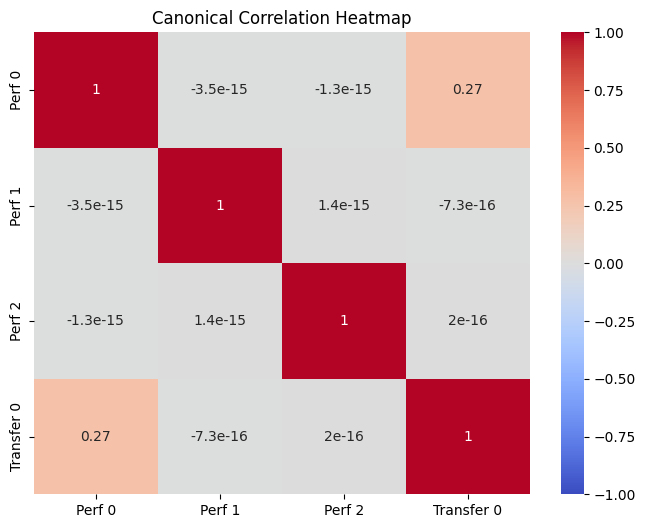

In [201]:
# Plot canonical correlations
print("\nMatrix Correlation of Canonical Variables :")

df_T = pd.DataFrame()
for k in range(X_c.shape[1]):
    df_T['Perf ' + str(k)] = X_c[:, k]

for k in range(Y_c.shape[1]): 
    df_T['Transfer ' + str(k)] = Y_c[:, k]

# Calcul de la matrice de corrélation croisée
new_cross_corr = df_T.corr()

# Affichage de la carte thermique de la matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(new_cross_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Canonical Correlation Heatmap")
plt.show()


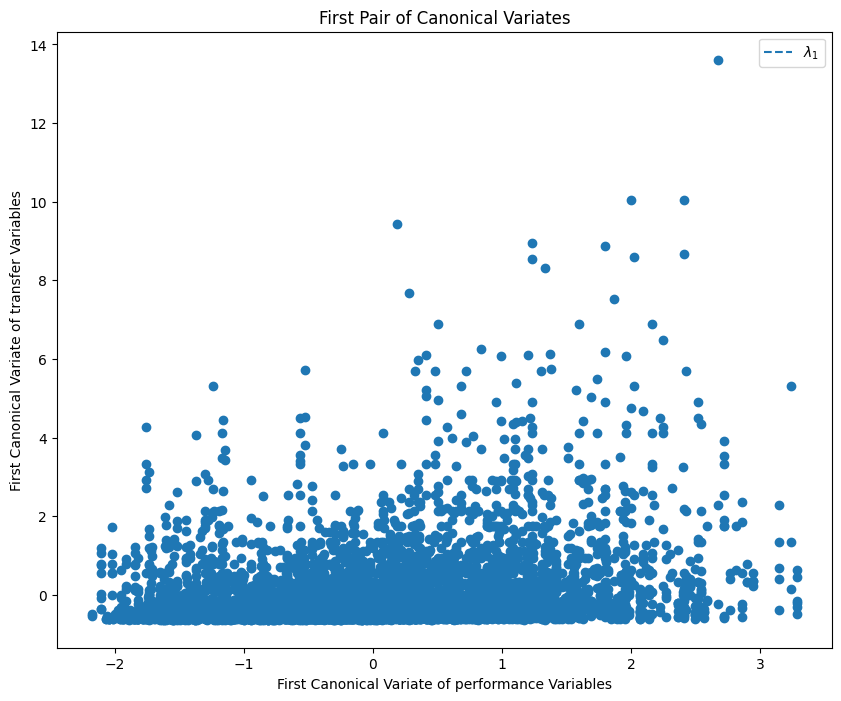

In [202]:
# Plot the first pair of canonical variates
plt.figure(figsize=(10, 8))
plt.scatter(X_c[:, 0], Y_c[:, 0])
plt.plot(np.linspace(-1.5, 1.5, 100), sing_value[0] * np.linspace(-1.5, 1.5, 100), '--', label=r'$\lambda_1$')
plt.xlabel('First Canonical Variate of performance Variables')
plt.ylabel('First Canonical Variate of transfer Variables')
plt.title('First Pair of Canonical Variates')
plt.legend()
plt.show()


In [203]:
def plot_correlation_circles(X, Y, X_c, Y_c, X_names=None, Y_names=None, X_can=None, Y_can=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Correlations for X original variables with X canonical variables
    x_loadings_x = np.corrcoef(X.T, X_c.T)[:X.shape[1], X.shape[1]:]
    
    # Correlations for Y original variables with X canonical variables
    y_loadings_x = np.corrcoef(Y.T, X_c.T)[:Y.shape[1], X_c.shape[1]:]

    # Correlations for X original variables with Y canonical variables
    x_loadings_y = np.corrcoef(X.T, Y_c.T)[:X.shape[1], Y_c.shape[1]:]
    
    # Correlations for Y original variables with Y canonical variables
    y_loadings_y = np.corrcoef(Y.T, Y_c.T)[:Y.shape[1], Y_c.shape[1]:]

    # Plot relative to X canonical variables
    ax1.set_title('Correlation Circle (X Canonical Variables)')
    for i in range(X.shape[1]):
        ax1.arrow(0, 0, x_loadings_x[i, 0], x_loadings_x[i, 1], 
                  head_width=0.05, head_length=0.05, fc='blue', ec='blue', length_includes_head=True)
        if X_names is None:
            ax1.text(x_loadings_x[i, 0]*1.15, x_loadings_x[i, 1]*1.15, f'X{i+1}', color='blue')
        else:
            ax1.text(x_loadings_x[i, 0]*1.15, x_loadings_x[i, 1]*1.15, X_names[i], color='blue')
    for i in range(Y.shape[1]):
        ax1.arrow(0, 0, y_loadings_x[i, 0], 0,  # CC2 contribution for Y is zero since it has only one dimension
                  head_width=0.05, head_length=0.05, fc='red', ec='red', length_includes_head=True)
        if Y_names is None:
            ax1.text(y_loadings_x[i, 0]*1.15, 0.15, f'Y{i+1}', color='red')
        else:
            ax1.text(y_loadings_x[i, 0]*1.15, 0.15, Y_names[i], color='red')

    ax1.add_artist(plt.Circle((0, 0), 1, color='gray', fill=False))
    ax1.axhline(y=0, color='k', linestyle='--')
    ax1.axvline(x=0, color='k', linestyle='--')
    ax1.set_xlim(-1.2, 1.2)
    ax1.set_ylim(-1.2, 1.2)
    ax1.set_aspect('equal')
    if X_can is not None:
        ax1.set_xlabel('X (' + X_can + ') CC1')
        ax1.set_ylabel('X (' + X_can + ') CC2')
    else:
        ax1.set_xlabel('X CC1')
        ax1.set_ylabel('X CC2')

    # Plot relative to Y canonical variables
    ax2.set_title('Correlation Circle (Y Canonical Variables)')
    for i in range(X.shape[1]):
        ax2.arrow(0, 0, x_loadings_y[i, 0], 0,  # CC2 contribution is zero for single-variable Y
                  head_width=0.05, head_length=0.05, fc='blue', ec='blue', length_includes_head=True)
        if X_names is None:
            ax2.text(x_loadings_y[i, 0]*1.15, 0.15, f'X{i+1}', color='blue')
        else:
            ax2.text(x_loadings_y[i, 0]*1.15, 0.15, X_names[i], color='blue')
    for i in range(Y.shape[1]):
        ax2.arrow(0, 0, y_loadings_y[i, 0], 0,  # CC2 contribution is zero for single-variable Y
                  head_width=0.05, head_length=0.05, fc='red', ec='red', length_includes_head=True)
        if Y_names is None:
            ax2.text(y_loadings_y[i, 0]*1.15, 0.15, f'Y{i+1}', color='red')
        else:
            ax2.text(y_loadings_y[i, 0]*1.15, 0.15, Y_names[i], color='red')

    ax2.add_artist(plt.Circle((0, 0), 1, color='gray', fill=False))
    ax2.axhline(y=0, color='k', linestyle='--')
    ax2.axvline(x=0, color='k', linestyle='--')
    ax2.set_xlim(-1.2, 1.2)
    ax2.set_ylim(-1.2, 1.2)
    ax2.set_aspect('equal')
    if Y_can is not None:
        ax2.set_xlabel('Y (' + Y_can + ') CC1')
        ax2.set_ylabel('Y (' + Y_can + ') CC2')
    else:
        ax2.set_xlabel('Y CC1')
        ax2.set_ylabel('Y CC2')

    plt.tight_layout()
    plt.show()

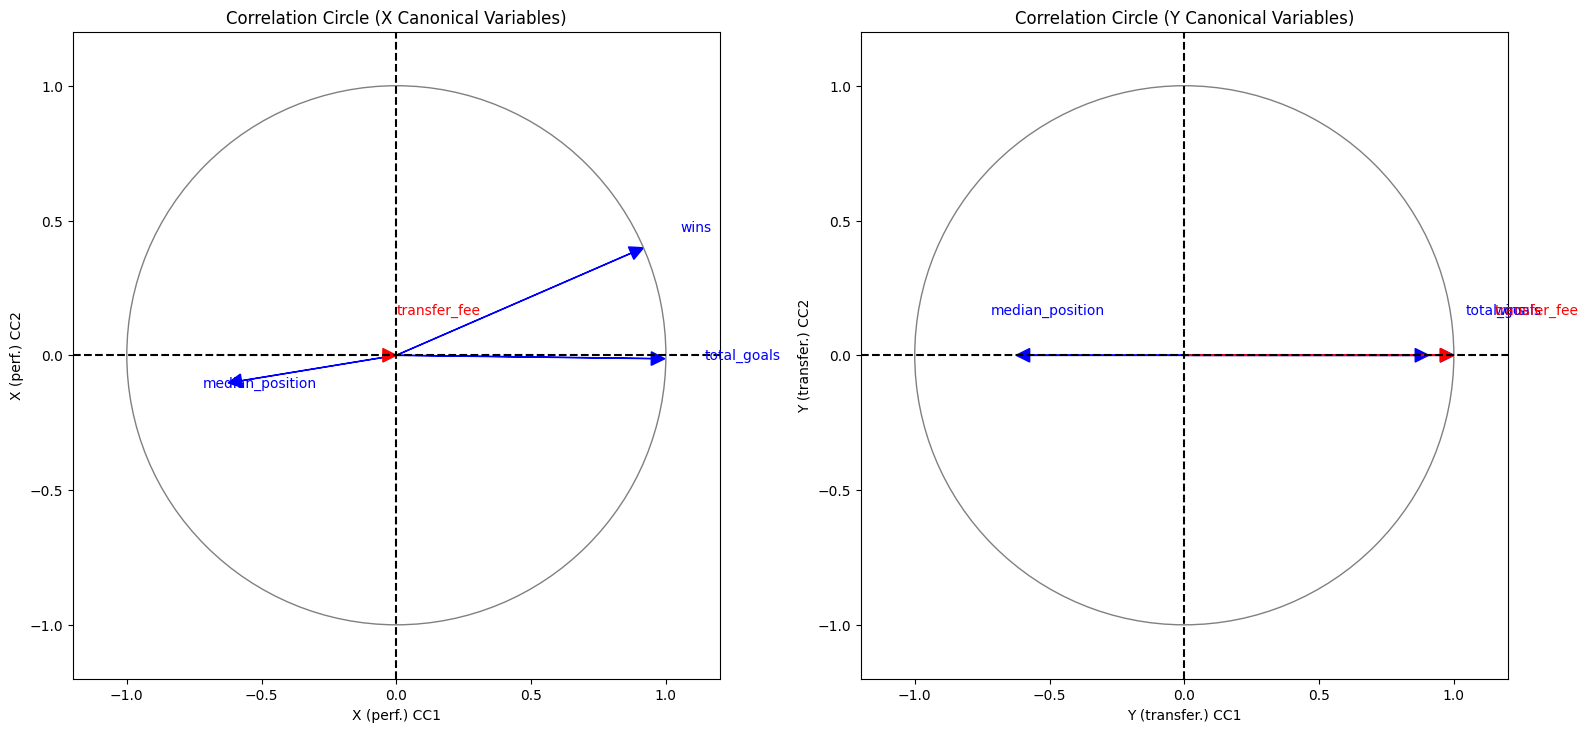

In [204]:
plot_correlation_circles( X_receiver, Y_receiver, X_c,Y_c,X_names= np.array(['total_goals', 'wins', 'median_position']), Y_names = np.array(['transfer_fee']), X_can = 'perf.', Y_can= 'transfer.')

In [205]:
# Contribution des variables dans les variantes canoniques
X_contributions = pd.DataFrame(a, index=['total_goals', 'wins', 'median_position'], columns=[f'Canonical Variate {i+1}' for i in range(a.shape[1])])
Y_contributions = pd.DataFrame(b, index=['transfer_fee'], columns=[f'Canonical Variate {i+1}' for i in range(b.shape[1])])

print("\nContributions des variables explicatives (X):")
print(X_contributions)
print("\nContributions des variables de transfert (Y):")
print(Y_contributions)

# Affichage des valeurs singulières
print("\nValeurs singulières :")
for i, sv in enumerate(sing_value):
    print(f"Valeur singulière {i + 1}: {sv:.4f}")



Contributions des variables explicatives (X):
                 Canonical Variate 1  Canonical Variate 2  Canonical Variate 3
total_goals                 0.044944            -0.102555             0.022627
wins                        0.000298             0.341896             0.045512
median_position            -0.020583             0.055376             0.235483

Contributions des variables de transfert (Y):
              Canonical Variate 1
transfer_fee         7.914629e-08

Valeurs singulières :
Valeur singulière 1: 0.2706


In [ ]:
# Same work for sender club
# Définir les deux ensembles de variables
X_sender = sender_club_data[['total_goals', 'wins', 'median_position']]  # Performances
Y_sender = sender_club_data[['transfer_fee']]  # Transferts

<Axes: >

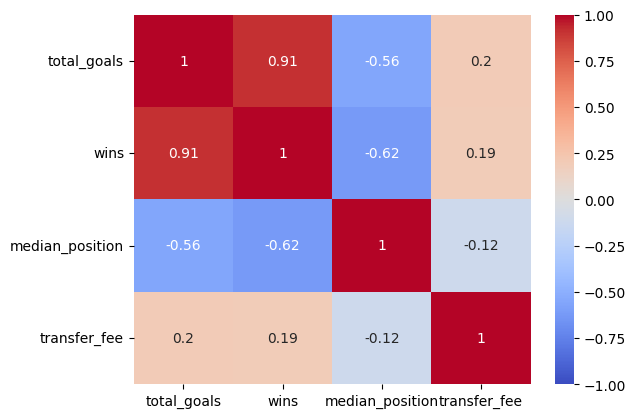

In [207]:
df_transfer = pd.concat([X_sender, Y_sender],axis=1)

# Calculer la matrice de corrélation
corr_matrix_transfer = df_transfer.corr()

# Créer une heatmap de la matrice de corrélation
sns.heatmap(corr_matrix_transfer, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)


In [208]:
X_c, Y_c, a, b, sing_value = canonical_correlation_analysis(np.array(X_sender), np.array(Y_sender))

# Contribution des variables dans les variantes canoniques
X_contributions = pd.DataFrame(a, index=['total_goals', 'wins', 'median_position'], columns=[f'Canonical Variate {i+1}' for i in range(a.shape[1])])
Y_contributions = pd.DataFrame(b, index=['transfer_fee'], columns=[f'Canonical Variate {i+1}' for i in range(b.shape[1])])

print("\nContributions des variables explicatives (X):")
print(X_contributions)
print("\nContributions des variables de transfert (Y):")
print(Y_contributions)

# Affichage des valeurs singulières
print("\nValeurs singulières :")
for i, sv in enumerate(sing_value):
    print(f"Valeur singulière {i + 1}: {sv:.4f}")



Contributions des variables explicatives (X):
                 Canonical Variate 1  Canonical Variate 2  Canonical Variate 3
total_goals                 0.038411            -0.104948             0.017956
wins                        0.028284             0.339240             0.047094
median_position             0.003158             0.047440             0.245169

Contributions des variables de transfert (Y):
              Canonical Variate 1
transfer_fee         6.916343e-08

Valeurs singulières :
Valeur singulière 1: 0.2030


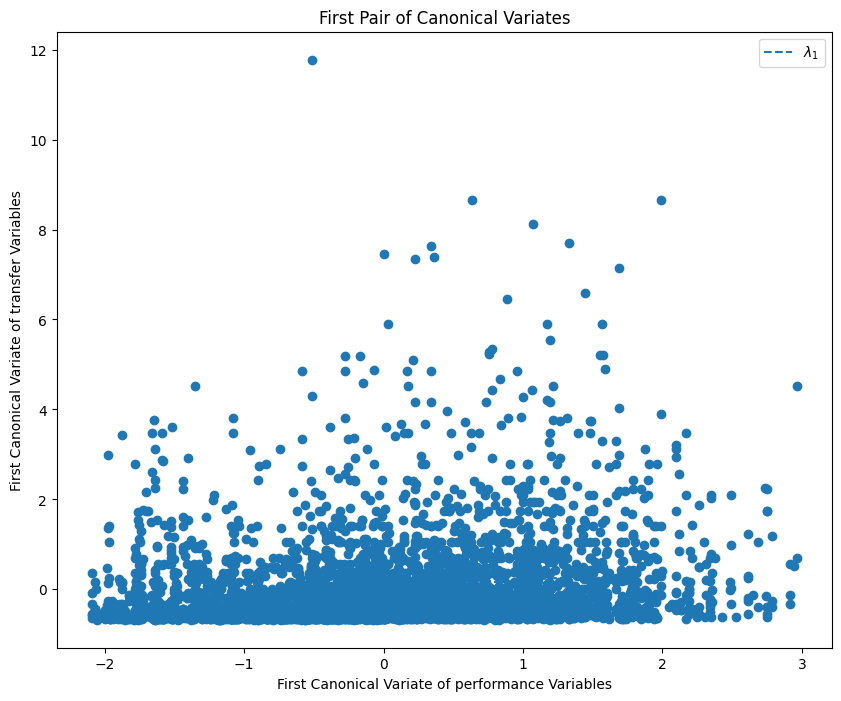

In [209]:
# Plot the first pair of canonical variates
plt.figure(figsize=(10, 8))
plt.scatter(X_c[:, 0], Y_c[:, 0])
plt.plot(np.linspace(-1.5, 1.5, 100), sing_value[0] * np.linspace(-1.5, 1.5, 100), '--', label=r'$\lambda_1$')
plt.xlabel('First Canonical Variate of performance Variables')
plt.ylabel('First Canonical Variate of transfer Variables')
plt.title('First Pair of Canonical Variates')
plt.legend()
plt.show()


Matrix Correlation of Canonical Variables :


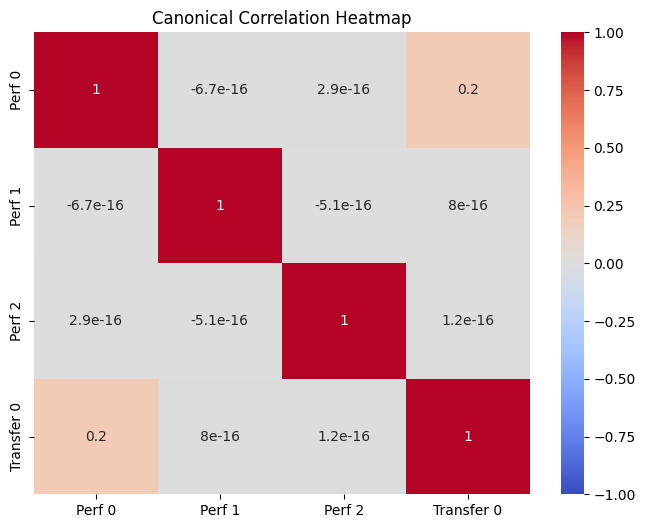

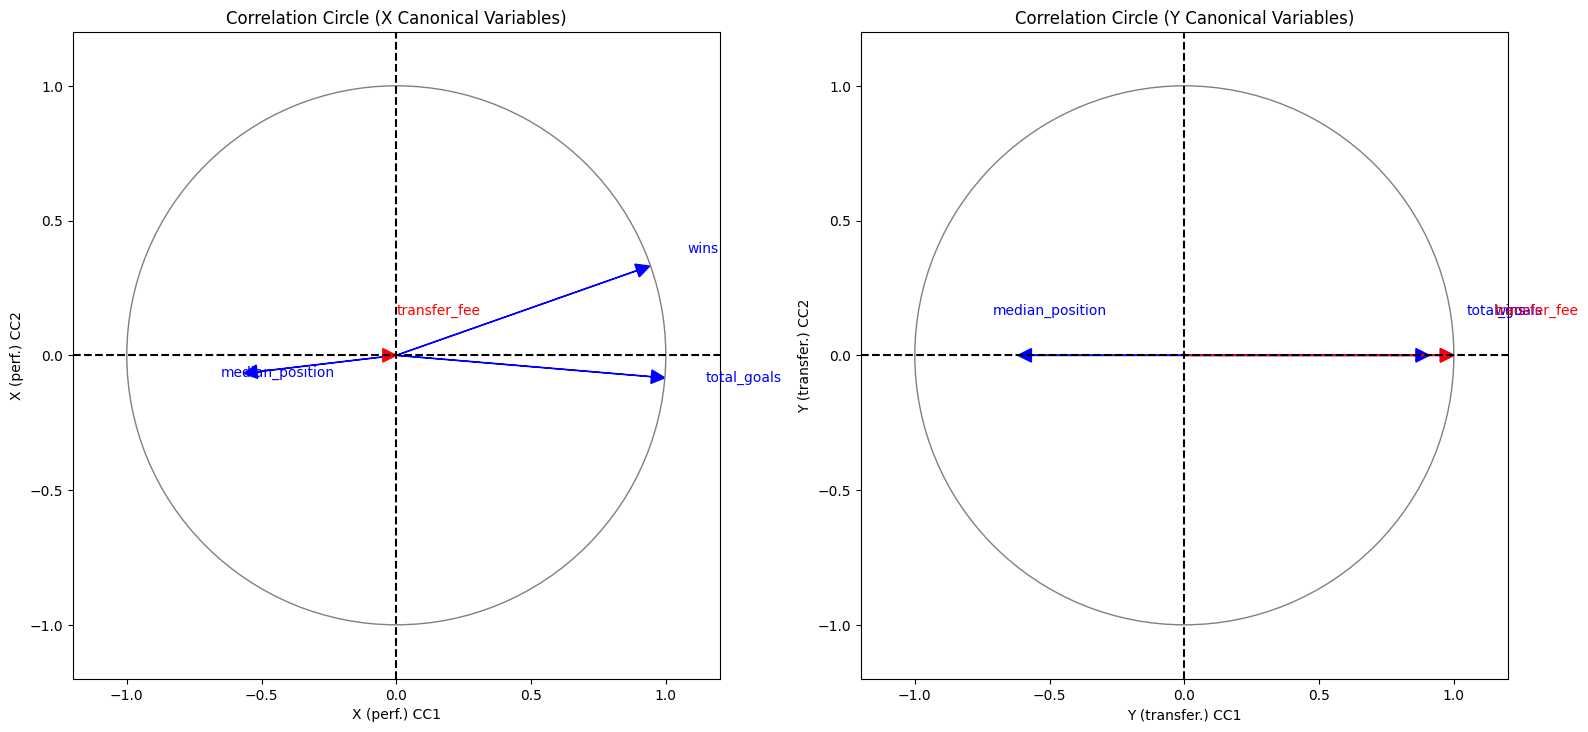

In [213]:
# Plot canonical correlations
print("\nMatrix Correlation of Canonical Variables :")

df_T = pd.DataFrame()
for k in range(X_c.shape[1]):
    df_T['Perf ' + str(k)] = X_c[:, k]

for k in range(Y_c.shape[1]): 
    df_T['Transfer ' + str(k)] = Y_c[:, k]

# Calcul de la matrice de corrélation croisée
new_cross_corr = df_T.corr()

# Affichage de la carte thermique de la matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(new_cross_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Canonical Correlation Heatmap")
plt.show()

plot_correlation_circles( X_sender, Y_sender, X_c,Y_c,X_names= np.array(['total_goals', 'wins', 'median_position']), Y_names = np.array(['transfer_fee']), X_can = 'perf.', Y_can= 'transfer.')